In [10]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
sys.path.append("../utils/")

In [12]:
from utils import r6io
from utils import features
from utils import plotting

In [13]:
pd.options.display.float_format = '{:.4f}'.format

In [14]:
df = r6io.read_player_csv('../data/leaderboard-pages.csv', 'ps4', **{"nrows": 10000})
df = df.reset_index()

In [15]:
numbers = features.columns_for_stats(df)

In [16]:
df_stats = df[numbers].copy().fillna(0)

In [17]:
df_stats.head(1).T

,0
stats.progression.level,99.0000
stats.progression.xp,38485.0000
stats.overall.assists,557.0000
stats.overall.barricades_built,1084.0000
stats.overall.bullets_fired,92244.0000
stats.overall.bullets_hit,19630.0000
stats.overall.headshots,702.0000
stats.overall.melee_kills,56.0000
stats.overall.penetration_kills,177.0000
stats.overall.reinforcements_deployed,2316.0000


In [18]:
df_stats['stats.overall.playtime'] = features.calc_total_playtime(df_stats)

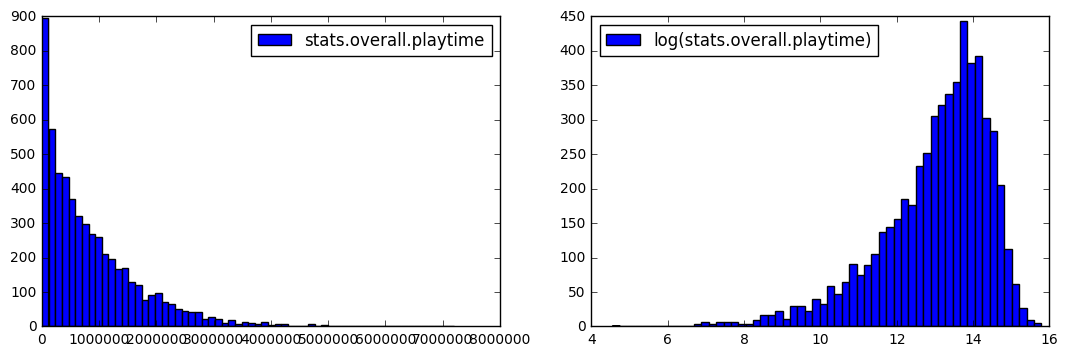

In [132]:
X = df_stats['stats.overall.playtime'].replace(np.inf, 0)
fig = plt.figure(figsize=(13,4), dpi=100)

plt.subplot(1, 2, 1)
plt.hist(X, bins='auto', label=X.name)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(np.log(X), bins='auto', label="log({})".format(X.name))
plt.legend(loc='upper left')

plt.show()